### Predicting Emotional Sentiment

In [1]:
import pandas as pd
import numpy as np
import nltk
import contractions
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
# import nltk
# nltk.download('punkt', download_dir='Users/kenchatg/local/share/nltk_data')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# _ = nltk.download('stopwords', quiet=True)
# _ = nltk.download('punkt', quiet=True)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

In [2]:
# Initialize lemmatizer

lemmatizer = WordNetLemmatizer()

# Get stopwords
stop_words = set(stopwords.words('english'))

# Add custom stopwords specific to mental health domain
custom_stopwords = {'feel', 'feeling', 'feelings', 'like', 'would', 'could', 'should', 'get', 'got', 'getting', 'go', 'going', 'went', 'gone'}
stop_words.update(custom_stopwords)

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) 
              for word in tokens 
              if word not in stop_words and len(word) > 2]
    
    return ' '.join(tokens)

In [3]:
# Load the dataset
data = pd.read_csv('mental_health_data.csv')

# Preprocessing

# Remove the rows with missing values
data = data.dropna()

# Remove the rows with repeated entries in the statement column
data = data.drop_duplicates(subset='statement')

# Apply preprocessing
data['processed_text'] = data['statement'].apply(preprocess_text)

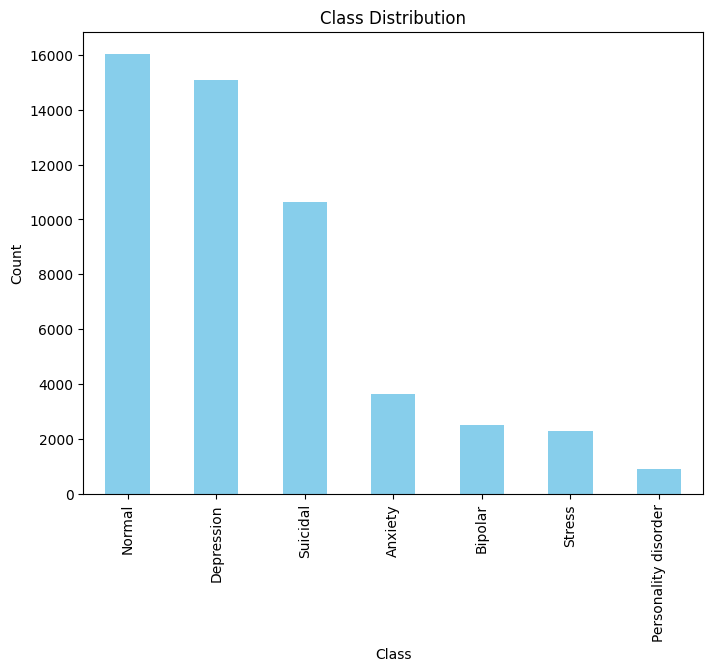

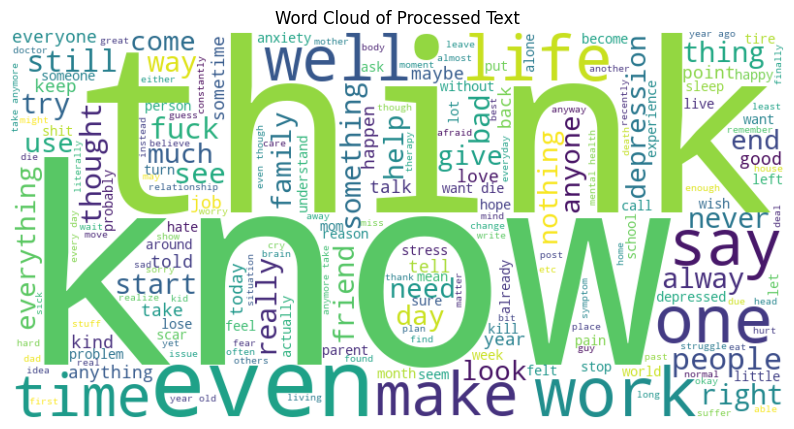

In [7]:
! pip install wordcloud
from collections import Counter
from wordcloud import WordCloud

# Plot class distribution
plt.figure(figsize=(8, 6))
data['status'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Generate a word cloud for the processed text
all_words = ' '.join(data['processed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Processed Text')
plt.show()

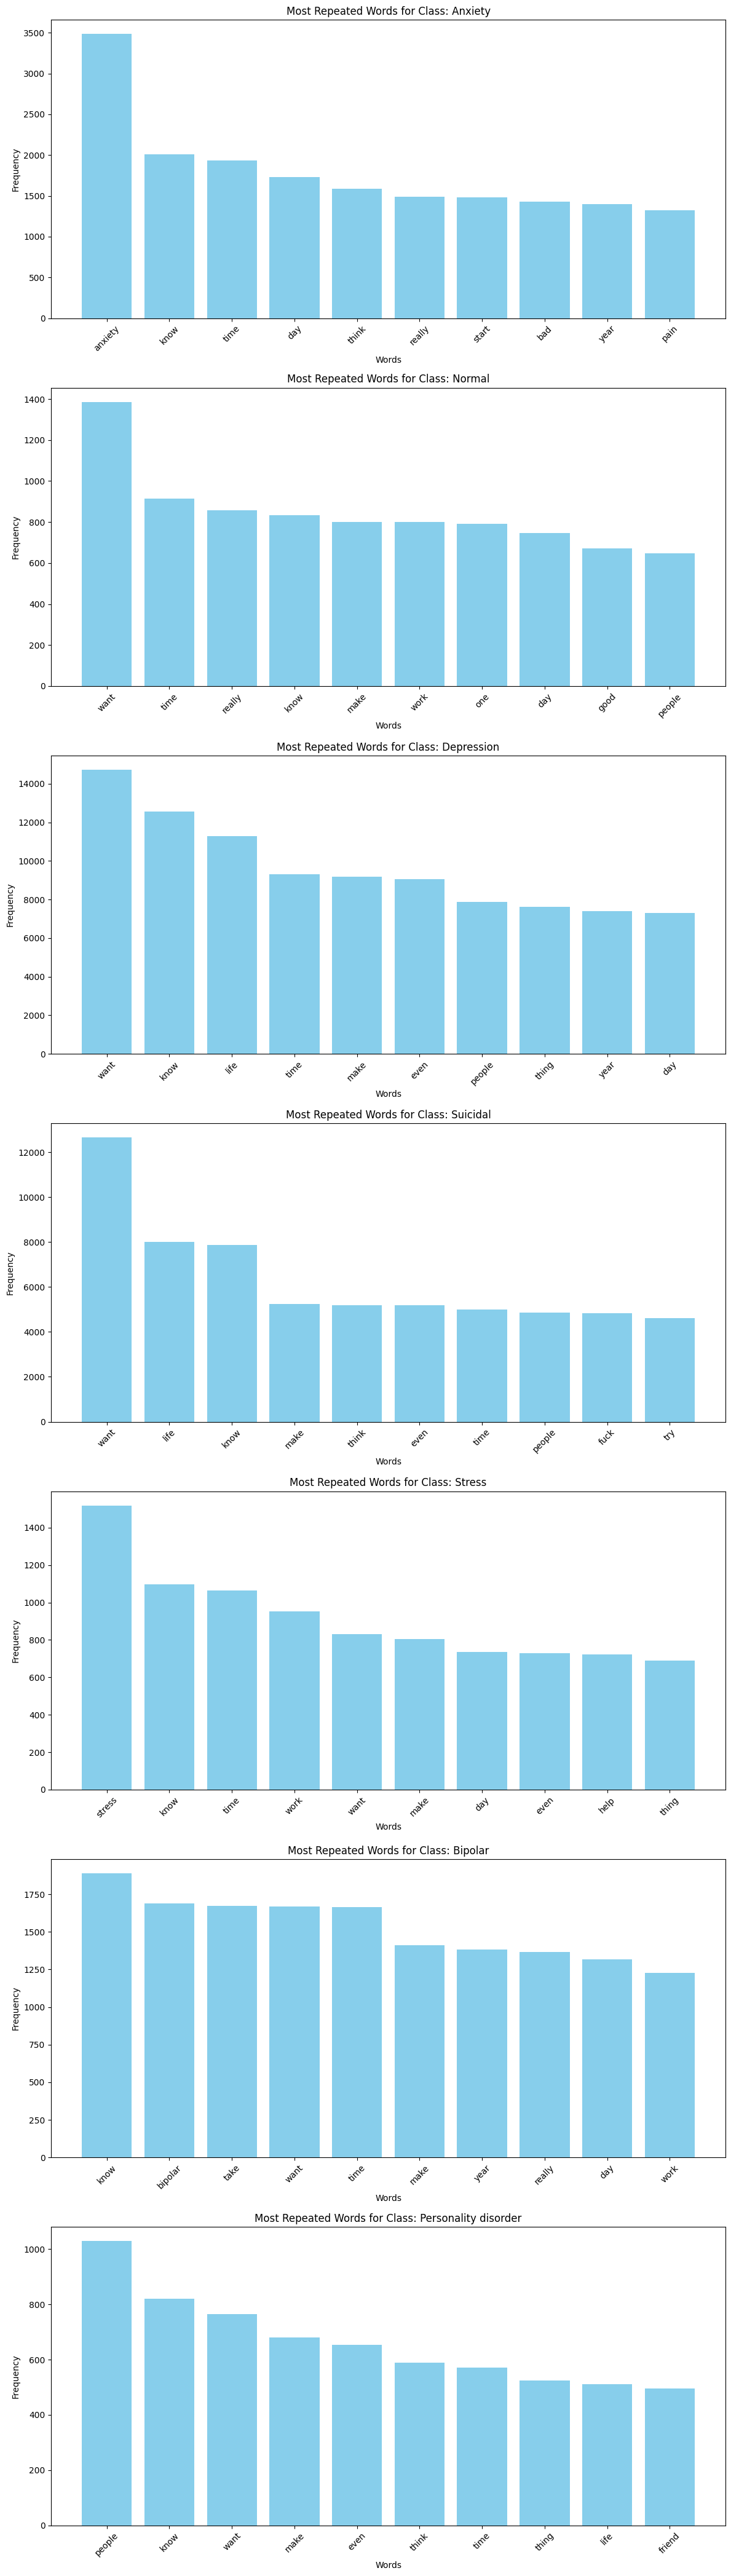

In [9]:
from collections import Counter
# Group data by class and count word frequencies for each class
class_word_counts = {}
for cls in data['status'].unique():
    filtered_data = data[data['status'] == cls]
    word_counts = Counter(' '.join(filtered_data['processed_text']).split())
    class_word_counts[cls] = word_counts.most_common(10)  # Top 10 words for each class

# Plot the graph for each class
fig, axes = plt.subplots(len(class_word_counts), 1, figsize=(12, 6 * len(class_word_counts)))
if len(class_word_counts) == 1:
    axes = [axes]  # Ensure axes is iterable for a single class

for ax, (cls, words_counts) in zip(axes, class_word_counts.items()):
    words, counts = zip(*words_counts)
    ax.bar(words, counts, color='skyblue')
    ax.set_title(f'Most Repeated Words for Class: {cls}')
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45)

plt.tight_layout()
plt.show()

In [4]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(data['processed_text'], data['status'], test_size=0.2, random_state=42)

# Create and fit TF-IDF vectorizer with improved parameters
tfidf = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 1),  # Include both unigrams and bigrams
    min_df=3,  # Minimum document frequency
    max_df=0.95,  # Maximum document frequency
    sublinear_tf=True,  # Apply sublinear scaling to term frequencies
    use_idf=True,  # Enable IDF
    smooth_idf=True,  # Smooth IDF weights
    norm='l2'  # Normalize TF-IDF vectors
)

# Transform the text data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [16]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(
    loss='hinge',
    penalty='l2',
    alpha=0.0001,
    max_iter=1000,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Train the model
sgd.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = sgd.predict(X_test_tfidf)

# Print results
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}\n")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7302006852667645


Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.76      0.79      0.77       738
             Bipolar       0.88      0.68      0.77       508
          Depression       0.67      0.66      0.67      2989
              Normal       0.81      0.95      0.88      3294
Personality disorder       0.95      0.28      0.43       194
              Stress       0.66      0.21      0.32       454
            Suicidal       0.62      0.63      0.62      2038

            accuracy                           0.73     10215
           macro avg       0.76      0.60      0.64     10215
        weighted avg       0.73      0.73      0.72     10215



In [ ]:
# Train Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=1.0)  # alpha=1.0 for Laplace smoothing
nb.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = nb.predict(X_test_tfidf)

# Print results
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}\n")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print top features for each class
print("\nTop 10 most important features for each class:")
feature_names = tfidf.get_feature_names_out()
for i, category in enumerate(nb.classes_):
    top10 = np.argsort(nb.feature_log_prob_[i])[-10:]
    print(f"\n{category}:")
    for idx in top10:
        print(f"{feature_names[idx]}: {np.exp(nb.feature_log_prob_[i][idx]):.4f}")

Test Accuracy: 0.6502202643171806


Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.81      0.63      0.71       738
             Bipolar       0.86      0.42      0.57       508
          Depression       0.50      0.79      0.61      2989
              Normal       0.83      0.77      0.80      3294
Personality disorder       0.92      0.06      0.11       194
              Stress       0.76      0.05      0.09       454
            Suicidal       0.67      0.50      0.57      2038

            accuracy                           0.65     10215
           macro avg       0.76      0.46      0.49     10215
        weighted avg       0.70      0.65      0.64     10215


Top 10 most important features for each class:

Anxiety:
time: 0.0040
worry: 0.0040
heart: 0.0040
day: 0.0042
symptom: 0.0043
know: 0.0044
worried: 0.0045
anxious: 0.0046
restless: 0.0070
anxiety: 0.0098

Bipolar:
want: 0.0036
time: 0.0038
really: 0.0038


In [15]:

def predict_all_classes(sentence):
    processed_sentence = preprocess_text(sentence)
    sentence_tfidf = tfidf.transform([processed_sentence])
    class_probabilities = nb.predict_proba(sentence_tfidf)
    class_predictions = {cls: prob for cls, prob in zip(nb.classes_, class_probabilities[0])}
    
    return class_predictions

def predict_class(sentence):
    processed_sentence = preprocess_text(sentence)
    sentence_tfidf = tfidf.transform([processed_sentence])
    predicted_class = nb.predict(sentence_tfidf)
    
    return predicted_class[0]

input_sentence = "I feel so anxious and restless these days."
predicted_class = predict_all_classes(input_sentence)
print(f"The predicted class for the input sentence is: {predicted_class}")

The predicted class for the input sentence is: {'Anxiety': 0.9101856776237968, 'Bipolar': 0.01643020240889823, 'Depression': 0.03387205817374212, 'Normal': 0.011457212061140025, 'Personality disorder': 0.0030051895660407695, 'Stress': 0.011820673364308969, 'Suicidal': 0.013228986802072896}
